In [350]:
import numpy as np  # For numerical computations
from scipy.optimize import minimize  # For numerical optimization
from sklearn.datasets import make_regression  # For generating synthetic datasets
from sklearn.linear_model import LinearRegression, Ridge  # For linear and ridge regression
from sklearn.preprocessing import PolynomialFeatures  # For polynomial feature generation
from sklearn.metrics import mean_squared_error, root_mean_squared_error  # For calculating mean squared error
import matplotlib.pyplot as plt  # For data visualization
import seaborn as sns  # For enhanced visualizations
import os  # For file operations

# Synthetic Data Generation

X shape: (2502, 1)
y shape: (2502,)


<Axes: title={'center': 'Synthetic Data'}, xlabel='X', ylabel='y'>

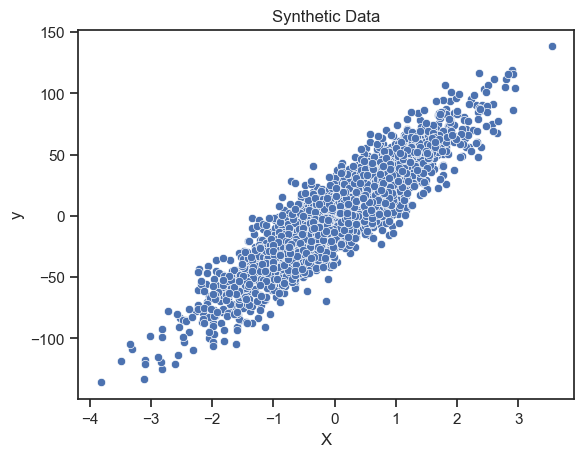

In [358]:
X, y = make_regression(n_samples=2502, n_features=1, noise=16, random_state=259202)

print("X shape:", X.shape) # X is N samples by D features [N,D]
print("y shape:", y.shape) # y is N samples [N,]

sns.set_context("notebook")
sns.set_style("ticks")
plt.xlabel('X')
plt.ylabel('y')
plt.title('Synthetic Data')
sns.scatterplot(x=X.flatten(),y=y)

# Analytical Linear Regression
Formula: w = (X^T X)^(-1) X^T y

w = [2,N] @ [N,2] = [2,2] ^ -1 -> [2,2] @ [2,N] = [2,N] -> [2,N] @ [N,] = [2,]


In [359]:
from sklearn.preprocessing import normalize


def analytical_linear_regression(X, y):

    X_ = np.c_[np.ones(X.shape[0]), X] # [N, D+1]

    w = np.linalg.inv(X_.T @ X_) @ X_.T @ y
    return w


weights = analytical_linear_regression(X, y)
print("w:", weights)

w: [-0.05959016 35.32283381]


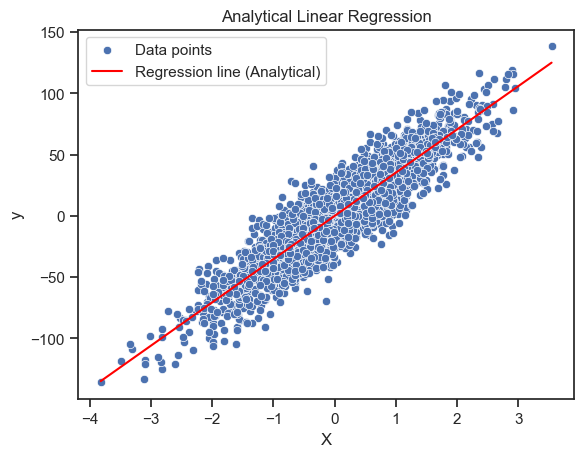

In [360]:
ones = np.ones(X.shape[0]) # [N,]
X_ = np.column_stack((ones, X)) 
y_pred = X_ @ weights

sns.set_context("notebook")
sns.set_style("ticks")
plt.xlabel('X')
plt.ylabel('y')
plt.title('Analytical Linear Regression')
sns.scatterplot(x=X.flatten(), y=y, label='Data points')
sns.lineplot(x=X.flatten(), y=y_pred, color='red', label='Regression line (Analytical)')
plt.legend()
plt.show()

# Numerical Linear Regression
Loss function L(w) = (1/N) * (y - X^T w)^T * (y - X^T w).

In [361]:
def loss_function(w, X, y):

    # [N, D+1] = [2502, 2]
    X_ = np.c_[np.ones(X.shape[0]), X] 
    
    y_pred = X_ @ w
    residuals = y - y_pred
    
    N = len(y)        
    loss = (1 / N) * (residuals.T @ residuals)

    return loss


result = minimize(
    fun=loss_function,
    x0=[100,-50],
    args=(X, y),
    method='Powell'
)

numerical_weights = result.x

print("w:", numerical_weights)
print("Iterations:", result.nit)
print("Evaluations", result.nfev)

w: [-0.05959002 35.32283381]
Iterations: 3
Evaluations 117


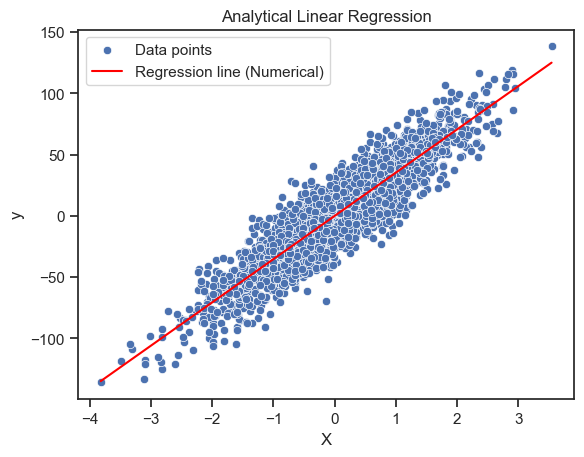

In [362]:
X_ = np.c_[np.ones(X.shape[0]), X]
y_pred_numerical = X_ @ numerical_weights

sns.set_context("notebook")
sns.set_style("ticks")
plt.xlabel('X')
plt.ylabel('y')
plt.title('Analytical Linear Regression')
sns.scatterplot(x=X.flatten(), y=y, label='Data points')
sns.lineplot(x=X.flatten(), y=y_pred_numerical, color='red', label='Regression line (Numerical)')
plt.legend()
plt.show()

In [363]:
import time

start_time = time.time()
for _ in range(1000):
    analytical_weights = analytical_linear_regression(X, y)
analytical_time = time.time() - start_time

start_time = time.time()
for _ in range(1000): 
    result = minimize(fun=loss_function, x0=[0,0], args=(X, y), method='Powell')
    numerical_weights = result.x
numerical_time = time.time() - start_time

print(f"Analytical time: {analytical_time:.6f} s")
print(f"Numerical time: {numerical_time:.6f} s")
print(f"Analitycal method is : {numerical_time/analytical_time:.2f}x faster than numerical method")

Analytical time: 0.067963 s
Numerical time: 0.816959 s
Analitycal method is : 12.02x faster than numerical method


In [364]:
filename = 'min_data.txt'
filepath = os.path.join("data", filename)

data = np.loadtxt(filepath, delimiter=',')
if filename == "min_data.txt":
    X_all = data[:, 0].reshape(-1, 1)
    y_all = data[:, 1]
    X_filtered = [X_all[0][0]]
    y_filtered = [y_all[0]]

    for i in range(1, len(y_all)):
        if y_all[i] != y_filtered[-1]:
            X_filtered.append(X_all[i][0])
            y_filtered.append(y_all[i])

    X = np.array(X_filtered).reshape(-1, 1)
    y = np.array(y_filtered)
else:
    X = data[:, 0].reshape(-1, 1)
    y = data[:, 1]

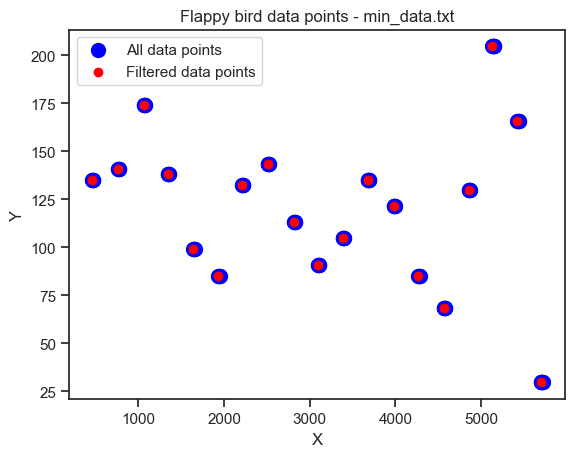

In [365]:
plt.scatter(X_all, y_all, color='blue',s=100, label='All data points') 
plt.scatter(X, y, color='red', label='Filtered data points')
plt.title('Flappy bird data points - min_data.txt')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

In [366]:
def load_data(filename):
    filepath = os.path.join("data", filename)
    data = np.loadtxt(filepath, delimiter=',')
    if filename == "min_data.txt":
        X_all = data[:, 0].reshape(-1, 1)
        y_all = data[:, 1]
        X_filtered = [X_all[0][0]]
        y_filtered = [y_all[0]]

        for i in range(1, len(y_all)):
            if y_all[i] != y_filtered[-1]:
                X_filtered.append(X_all[i][0])
                y_filtered.append(y_all[i])

        X = np.array(X_filtered).reshape(-1, 1)
        y = np.array(y_filtered)
    else:
        X = data[:, 0].reshape(-1, 1)
        y = data[:, 1]

    return X, y

In [367]:
def poly_regression(X, y, degree):

    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_poly = poly.fit_transform(X) # make X given polynomial

    model = LinearRegression().fit(X_poly, y) # fit model to polynomial features
    y_pred_sklearn = model.predict(X_poly) 

    mse = root_mean_squared_error(y, y_pred_sklearn)
    print(f"MSE sklearn (degree {degree}):", mse)

    w = analytical_linear_regression(X_poly, y) # [10,]
    X_ = np.c_[np.ones(X_poly.shape[0]), X_poly] # [19,9+1]
    y_pred_analytical = X_ @ w

    mse = root_mean_squared_error(y, y_pred_analytical)
    print(f"MSE analytical (degree {degree}):", mse,"\n")

    return model, w, poly

def compare_models(X, y):
    _, axs = plt.subplots(2, 2, figsize=(16, 12))
    
    degrees = [9, 21]

    for i, degree in enumerate(degrees):
        
        model, w, poly = poly_regression(X, y, degree)

        X_plot = np.linspace(X.min(), X.max(), 10000).reshape(-1, 1)
        X_plot_poly = poly.transform(X_plot)

        y_pred_sklearn = model.predict(X_plot_poly)

        X_plot_bias = np.c_[np.ones(X_plot_poly.shape[0]), X_plot_poly]
        y_pred_analytical = X_plot_bias @ w

        axs[i, 0].scatter(X, y, label='Data points')
        axs[i, 0].plot(X_plot, y_pred_sklearn, color="red")
        axs[i, 0].set_title(f'Degree {degree} - sklearn')
        axs[i, 0].set_xlabel('X')
        axs[i, 0].set_ylabel('Y')
        axs[i, 0].grid()
        axs[i, 0].legend()
        
        axs[i, 1].scatter(X, y, label='Data points')
        axs[i, 1].plot(X_plot, y_pred_analytical, color='green')
        axs[i, 1].set_title(f'Degree {degree} - Analytical')
        axs[i, 1].set_xlabel('X')
        axs[i, 1].set_ylabel('Y')
        axs[i, 1].grid()
        axs[i, 1].legend()

    plt.tight_layout()
    plt.suptitle(f'Polynomial Regression - {filename}', y=1.02, fontsize=16)
    plt.show()

min_data.txt
MSE sklearn (degree 9): 24.881259650234558
MSE analytical (degree 9): 20.22521397907855 

MSE sklearn (degree 21): 20.86570043778429
MSE analytical (degree 21): 9079.198608834035 



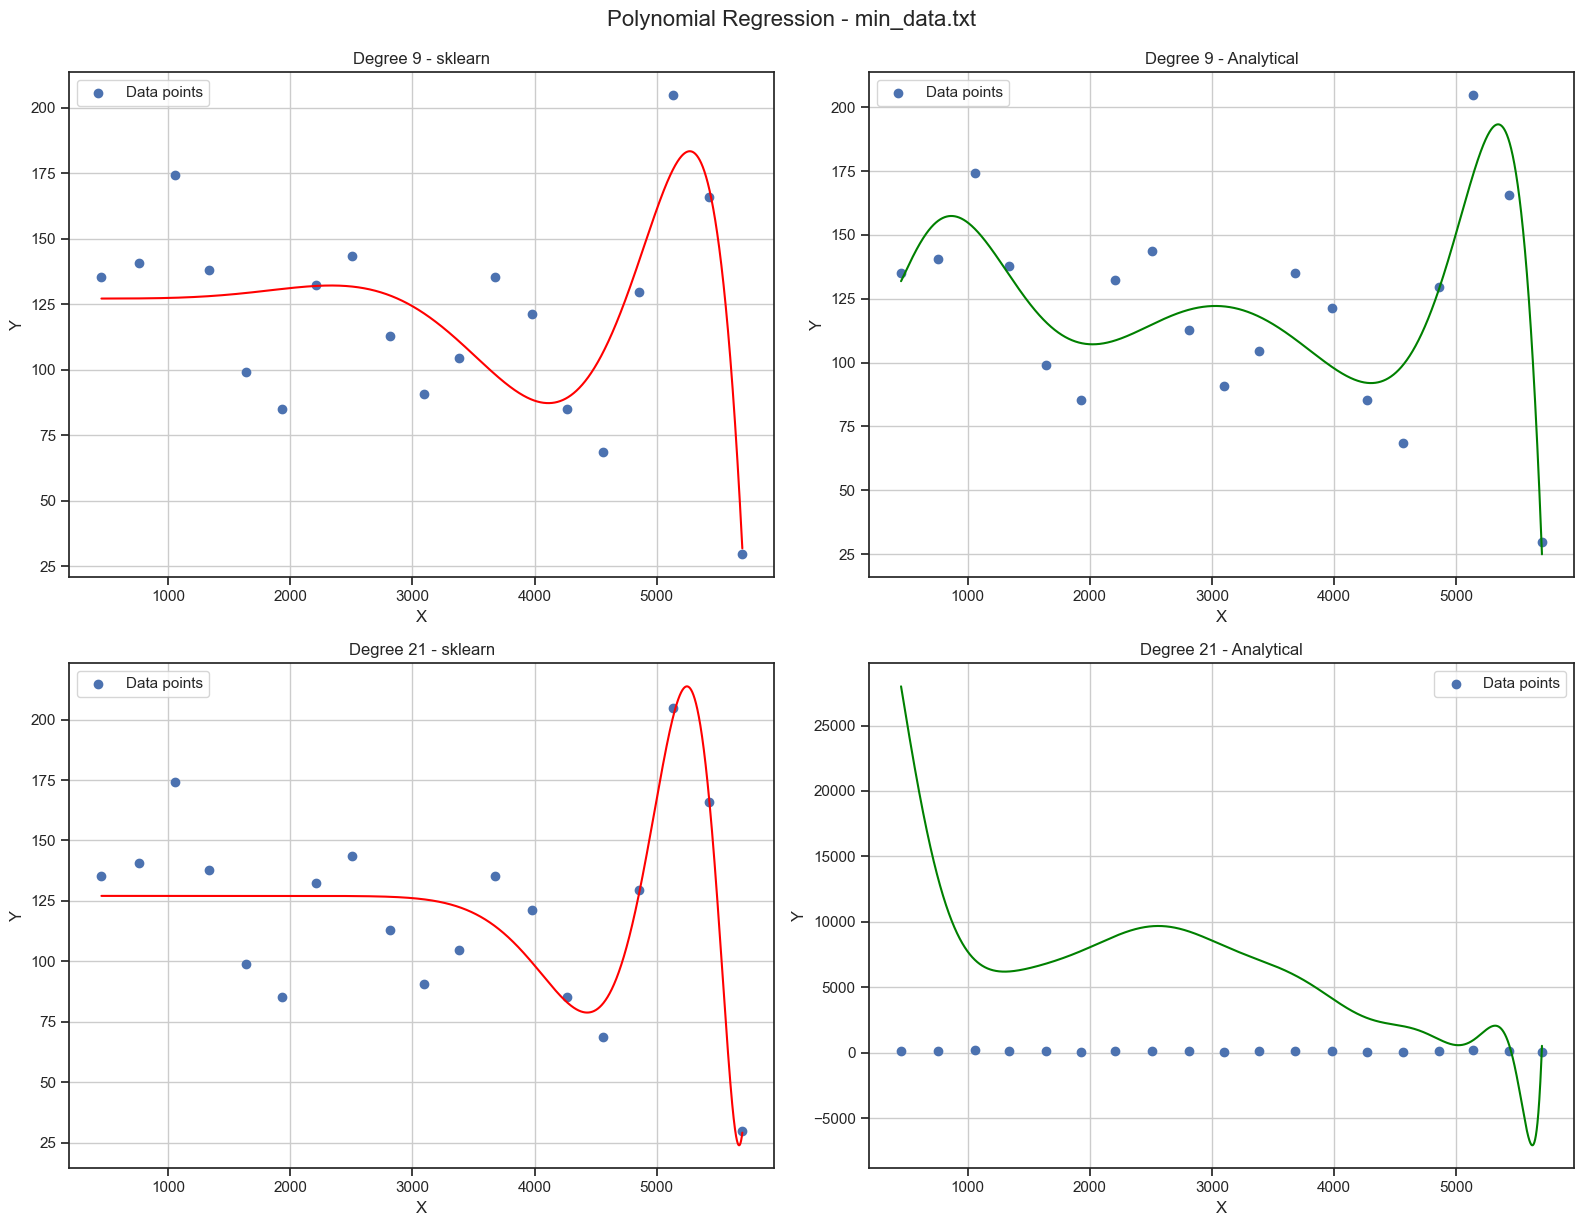

key_data.txt
MSE sklearn (degree 9): 22.93404067850906
MSE analytical (degree 9): 17.68245535543122 

MSE sklearn (degree 21): 20.42863577132871
MSE analytical (degree 21): 72977.62810984183 



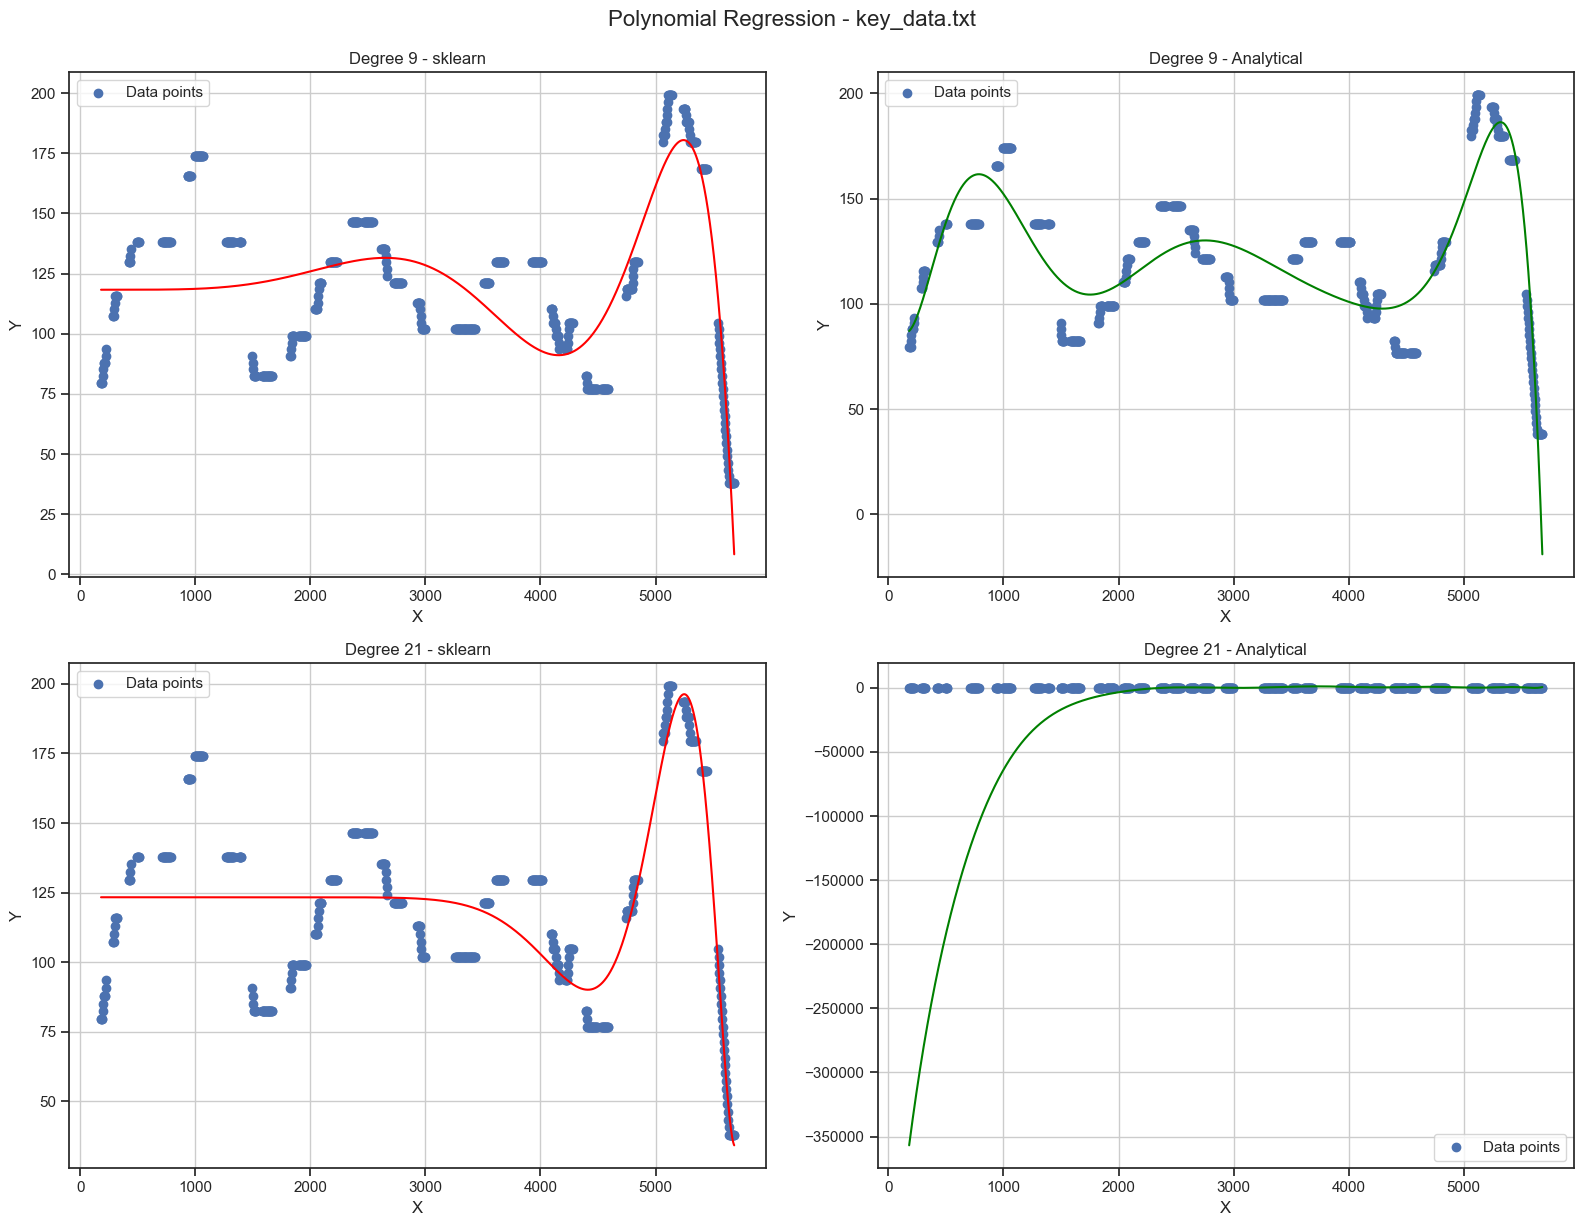

all_data.txt
MSE sklearn (degree 9): 26.75762921519036
MSE analytical (degree 9): 21.51134212878685 

MSE sklearn (degree 21): 23.89221175353501
MSE analytical (degree 21): 5918.039076787548 



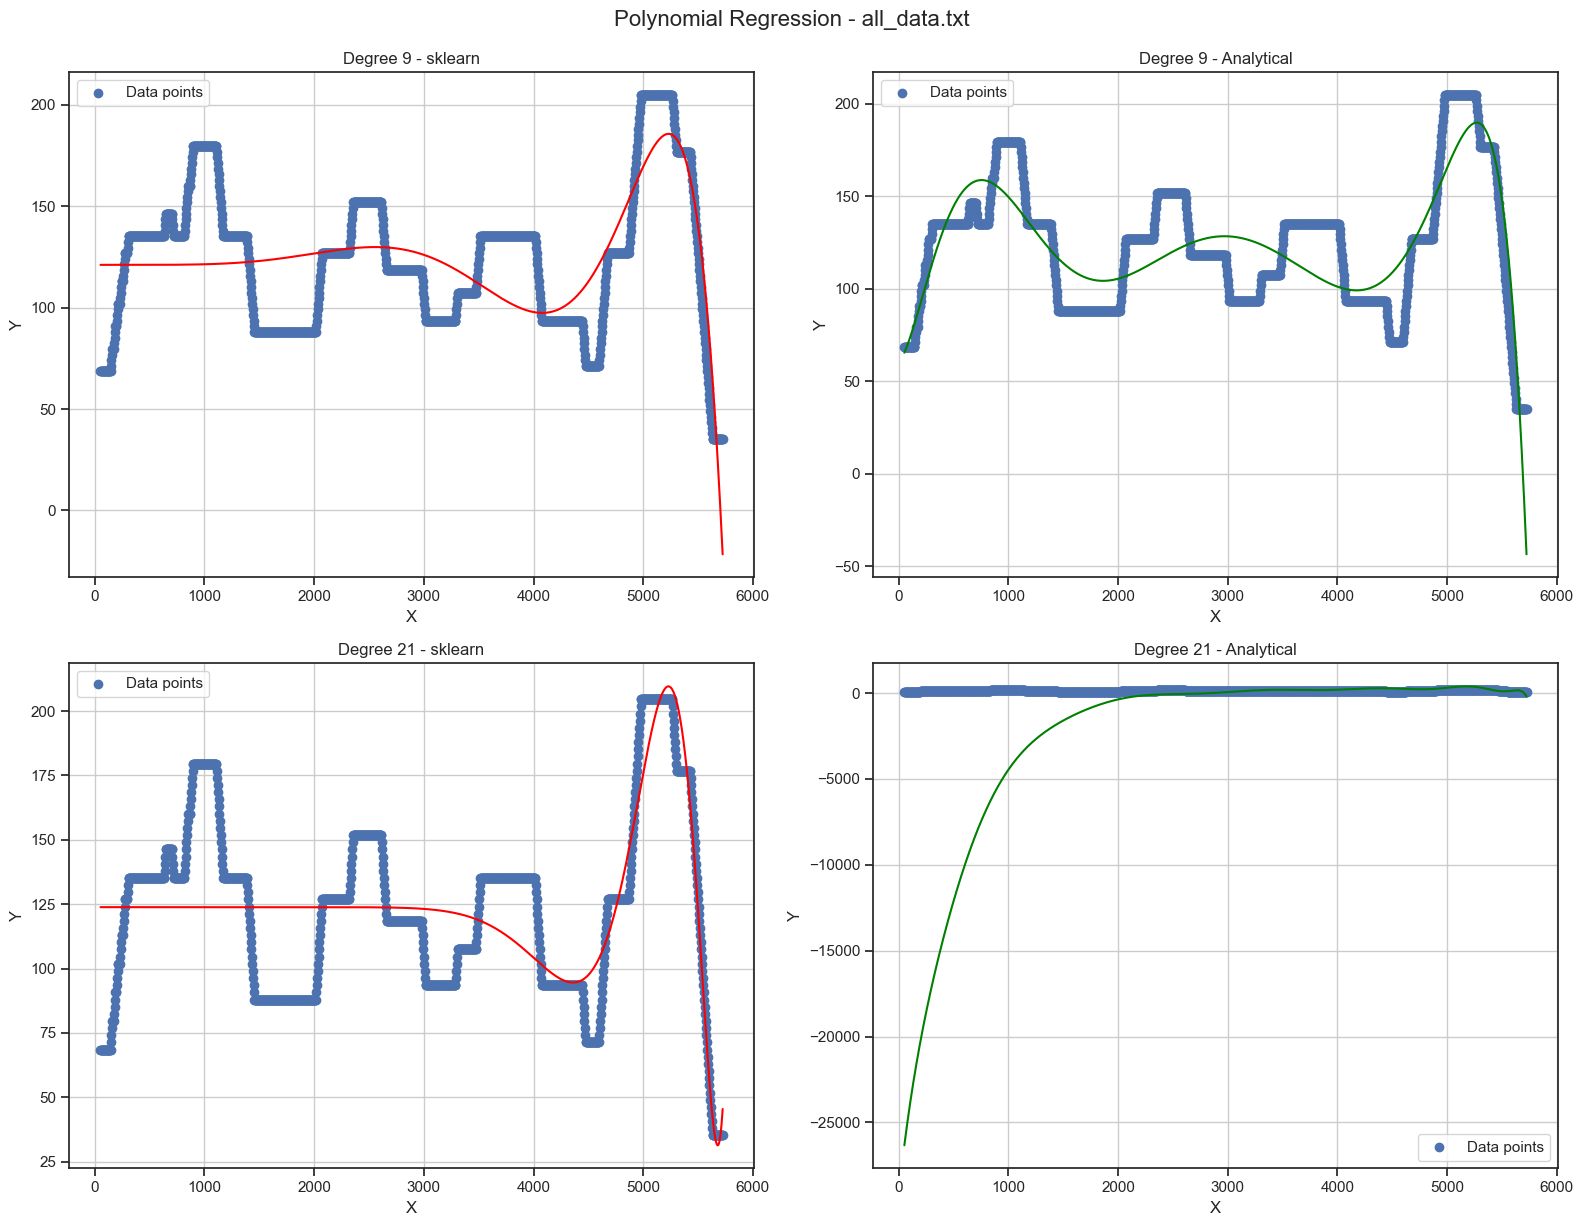

In [368]:
files = ["min_data.txt", "key_data.txt", "all_data.txt"]

for filename in files:
    print(filename)
    X, y = load_data(filename)
    compare_models(X, y)

For analytical polynomial regression:
* for poly with degree 9, analytical regression fits great
* for bigger degrees of polynomial its too much dimentions, for small amout of samples, without regularization analytical implementation is much worse than sklearn